In [1]:
import scipy.io
%matplotlib widget
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
import ydata_profiling as ppro
import rosbag
import csv

In [2]:
bag_stick = rosbag.Bag('../Data/datasets/biotac_single_contact_response/2018-01-19-18-16-58_biotac_ff_stick_calibration.bag')
bag_flat = rosbag.Bag('../Data/datasets/biotac_single_contact_response/2018-01-19-19-46-18_biotac_ff_flat_sensor_calibration.bag')

In [3]:
print(bag_stick)

path:         /media/malte/MassiveLOS/biotac_single_contact_response/2018-01-19-18-16-58_biotac_ff_stick_calibration.bag
version:      2.0
duration:     52:13s (3133s)
start:        Jan 19 2018 18:16:58.86 (1516382218.86)
end:          Jan 19 2018 19:09:12.74 (1516385352.74)
size:         220.2 MB
messages:     4685041
compression:  bz2 [1893/1893 chunks; 11.67%]
uncompressed:   1.4 GB @ 464.2 KB/s
compressed:   165.8 MB @  54.2 KB/s (11.67%)
types:        apriltags_ros/AprilTagDetectionArray [93c0a301ed9e6633dc34b8117d49ebd4]
              geometry_msgs/WrenchStamped          [d78d3cb249ce23087ade7e7d0c40cfa7]
              sr_robot_msgs/BiotacAll              [e27dd065f854b80a2d092dd322ddfd40]
              tams_biotac/Contact                  [1e24a2e0e5a210dc086bcdf787ab9c78]
              tf2_msgs/TFMessage                   [94810edda583a504dfda3829e70d7eec]
topics:       /tag_detections          25225 msgs @   8.1 Hz : apriltags_ros/AprilTagDetectionArray
              /tf      

In [4]:
print(bag_flat)

path:         /media/malte/MassiveLOS/biotac_single_contact_response/2018-01-19-19-46-18_biotac_ff_flat_sensor_calibration.bag
version:      2.0
duration:     33:38s (2018s)
start:        Jan 19 2018 19:46:18.96 (1516387578.96)
end:          Jan 19 2018 20:19:57.64 (1516389597.64)
size:         140.9 MB
messages:     3010640
compression:  bz2 [1180/1180 chunks; 11.97%]
uncompressed: 885.0 MB @ 448.9 KB/s
compressed:   105.9 MB @  53.7 KB/s (11.97%)
types:        apriltags_ros/AprilTagDetectionArray [93c0a301ed9e6633dc34b8117d49ebd4]
              geometry_msgs/WrenchStamped          [d78d3cb249ce23087ade7e7d0c40cfa7]
              sr_robot_msgs/BiotacAll              [e27dd065f854b80a2d092dd322ddfd40]
              tams_biotac/Contact                  [1e24a2e0e5a210dc086bcdf787ab9c78]
              tf2_msgs/TFMessage                   [94810edda583a504dfda3829e70d7eec]
topics:       /tag_detections          18025 msgs @   9.3 Hz : apriltags_ros/AprilTagDetectionArray
              /tf

In [5]:
electrodes_default=[2668, 3224, 3239, 3003, 3165, 2849, 2798, 2873, 2912, 3017, 2605, 3202, 3221, 3025, 3164, 2874, 3158, 3203, 3026]

# Flat Indenter

# Extract non contact steps

In [6]:
cool_down_steps = 200
in_contact = False
is_cooled_down = True
active_steps = 0
all_values = []
all_baseline_values = []

flat_trajecs = 0

indices = []
forces = []
forces_to_contact = []
i = 0
force_strength = 0.0
for ind, (topic, msg, t) in enumerate(bag_flat.read_messages(topics=['rh/tactile', 'wireless_ft/wrench_3'])):
    
    if topic == 'wireless_ft/wrench_3':
        force = np.array([msg.wrench.force.x, msg.wrench.force.y, msg.wrench.force.z])
        force_strength = np.linalg.norm(force)
        forces.append(force_strength)
        if force_strength > 0.3:
            if not in_contact:
                flat_trajecs += 1
            
            in_contact = True
            is_cooled_down = False
            active_steps = 0
            
        if force_strength < 0.3:
            in_contact = False
            active_steps += 1
            if active_steps >= cool_down_steps:
                is_cooled_down = True
    elif topic == 'rh/tactile':
        forces_to_contact.append(force_strength)
        electrode_values = np.array(msg.tactiles[0].electrodes)
        all_values.append(electrode_values)
        if not in_contact and is_cooled_down:
            all_baseline_values.append(electrode_values)
            indices.append(i)
        i += 1
            
all_values = np.array(all_values)
all_baseline_values = np.array(all_baseline_values)
all_forces_flat = np.array(forces)
all_forces_to_contact_flat = np.array(forces_to_contact)
print(all_forces_flat.shape)
print(all_forces_to_contact_flat.shape)
print(all_values.shape)
print(all_baseline_values.shape)
print(flat_trajecs)

(242500,)
(201869,)
(201869, 19)
(25539, 19)
1179


# Visualize filtered values

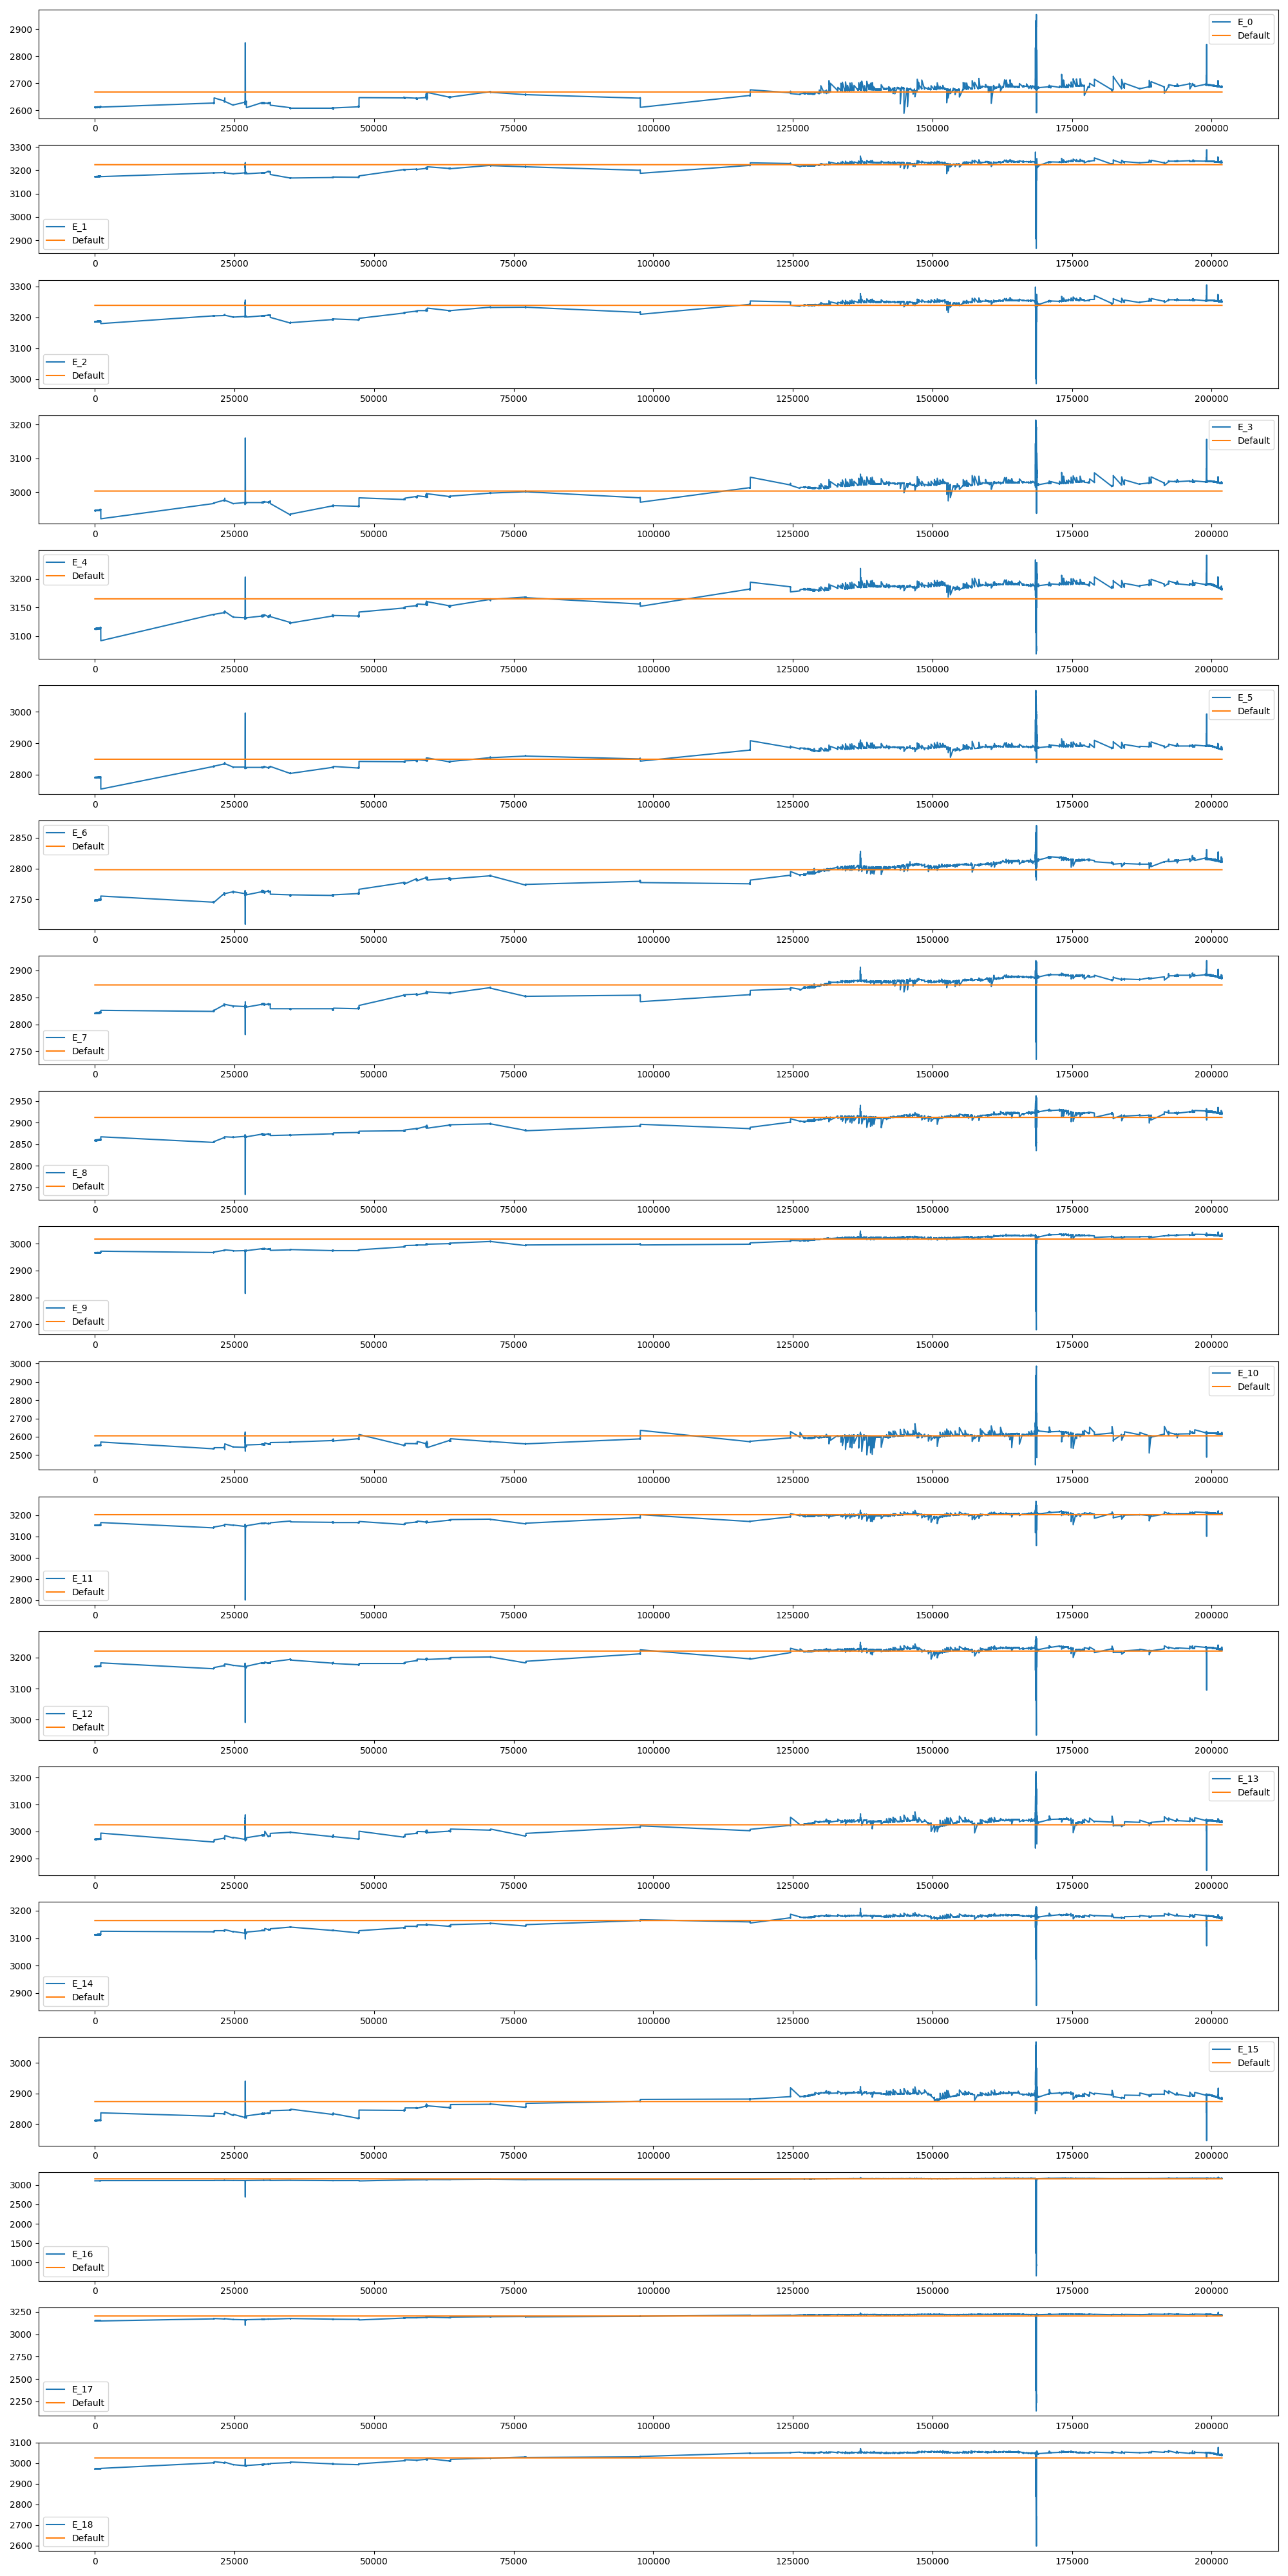

In [7]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(20, 40))

for i in range (19):
    ax2[i].plot(indices, all_baseline_values[:,i],label="E_"+str(i))
    ax2[i].plot(indices, [electrodes_default[i] for v in all_baseline_values[:, i]], label="Default")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

# Optimize linear error

In [8]:
from pathlib import Path
import torch
import tqdm

complete_res = []
fitted_values = []


for i in tqdm.tqdm(range(19)):
    function_weights = torch.tensor([0, all_baseline_values[0][i]], dtype=torch.float, requires_grad=True)
    
    ground_truth = torch.tensor(all_baseline_values, requires_grad=True, dtype=torch.float)[:, i]
    input_values = torch.tensor(indices, dtype=torch.float)
    steps = 10000
    optimizer = torch.optim.Adam([function_weights], lr= 1e-5)
    def forward(va):
        return function_weights[0] * va + function_weights[1]
    
    def loss(res, labels):
        return torch.mean(torch.abs(labels - res))

    dist = 0
    for k in range(steps):
        optimizer.zero_grad()
        res = forward(input_values)
        dist = loss(res, ground_truth)
        # pbar.set_description(f"Loss: {dist}")
        dist.backward()
        optimizer.step()
    
    print(f"{function_weights[0]} * x + {function_weights[1]}\nLoss: {dist}")
    
    fitted_values.append(forward(torch.tensor(np.arange(len(all_values)))))
    
    error_path = Path(f"./data/electrode_error_weights/flat/{i}")
    error_path.mkdir(parents=True, exist_ok=True)
    # np.save(error_path / "weights.npy", function_weights.detach().numpy())
    # np.save(error_path / "loss.npy", dist.detach().numpy())
    complete_res.append(forward(input_values).detach().numpy())

  5%|▌         | 1/19 [00:05<01:44,  5.80s/it]

0.00043938306043855846 * x + 2612.0
Loss: 6.931024551391602


 11%|█         | 2/19 [00:11<01:34,  5.59s/it]

0.000381792284315452 * x + 3172.0
Loss: 6.832296848297119


 16%|█▌        | 3/19 [00:16<01:29,  5.57s/it]

0.0004111558373551816 * x + 3186.0
Loss: 6.863167762756348


 21%|██        | 4/19 [00:22<01:23,  5.53s/it]

0.0005044067511335015 * x + 2945.0
Loss: 8.33543872833252


 26%|██▋       | 5/19 [00:27<01:18,  5.60s/it]

0.00047315371921285987 * x + 3113.0
Loss: 8.032759666442871


 32%|███▏      | 6/19 [00:33<01:12,  5.58s/it]

0.000605637498665601 * x + 2790.0
Loss: 11.279093742370605


 37%|███▋      | 7/19 [00:39<01:06,  5.55s/it]

0.0003804311854764819 * x + 2747.0
Loss: 3.979794502258301


 42%|████▏     | 8/19 [00:44<01:00,  5.54s/it]

0.0004009997355751693 * x + 2820.0
Loss: 4.687959671020508


 47%|████▋     | 9/19 [00:50<00:55,  5.52s/it]

0.0003702050307765603 * x + 2858.0
Loss: 4.2742791175842285


 53%|█████▎    | 10/19 [00:55<00:49,  5.53s/it]

0.0003753220080398023 * x + 2966.0
Loss: 5.319993495941162


 58%|█████▊    | 11/19 [01:01<00:44,  5.53s/it]

0.00035585189471021295 * x + 2551.0
Loss: 7.742295265197754


 63%|██████▎   | 12/19 [01:06<00:38,  5.51s/it]

0.00031820189906284213 * x + 3152.0
Loss: 5.42677116394043


 68%|██████▊   | 13/19 [01:12<00:33,  5.52s/it]

0.0003524396161083132 * x + 3171.0
Loss: 6.874850749969482


 74%|███████▎  | 14/19 [01:17<00:27,  5.52s/it]

0.00041845269151963294 * x + 2971.0
Loss: 9.24501895904541


 79%|███████▉  | 15/19 [01:23<00:22,  5.51s/it]

0.0004256167740095407 * x + 3112.0
Loss: 8.700785636901855


 84%|████████▍ | 16/19 [01:28<00:16,  5.49s/it]

0.0005377901252359152 * x + 2811.0
Loss: 12.834568977355957


 89%|████████▉ | 17/19 [01:34<00:10,  5.48s/it]

0.000374207942513749 * x + 3107.0
Loss: 12.764456748962402


 95%|█████████▍| 18/19 [01:39<00:05,  5.47s/it]

0.00044876738684251904 * x + 3149.0
Loss: 11.078388214111328


100%|██████████| 19/19 [01:44<00:00,  5.52s/it]

0.0005047275335527956 * x + 2972.0
Loss: 11.401883125305176


# Visualize found linear error

2612


Text(0, 0.5, 'Electrode Value')

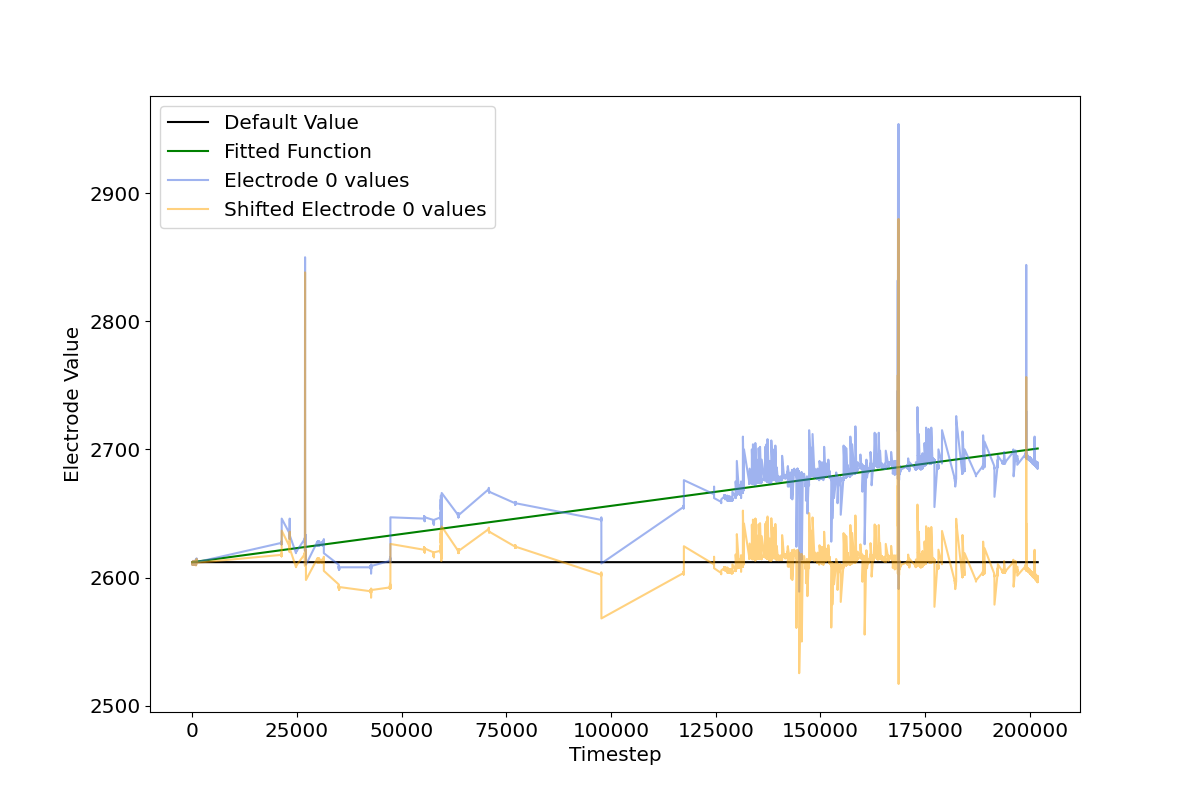

In [9]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig_, (ax2) = plt.subplots(1, 1, figsize=(12, 8))

k = 0
tmp = fitted_values[k].detach().numpy()

shifted_baseline_values = [(v - (tmp[i] - all_baseline_values[0,k])) for i, v in zip(indices, all_baseline_values[:,k])]

print(all_baseline_values[0,k])
ax2.plot(indices, [all_baseline_values[0,k] for v in all_baseline_values[:, k]], label="Default Value", color="black")
ax2.plot(indices, complete_res[k], label="Fitted Function", color="green")
ax2.plot(indices, all_baseline_values[:,k],label=f"Electrode {k} values", alpha=0.5, color="royalblue")
ax2.plot(indices, shifted_baseline_values, label=f"Shifted Electrode {k} values", alpha=0.5, color="orange")
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Electrode Value")






(0.0, 200000.0)

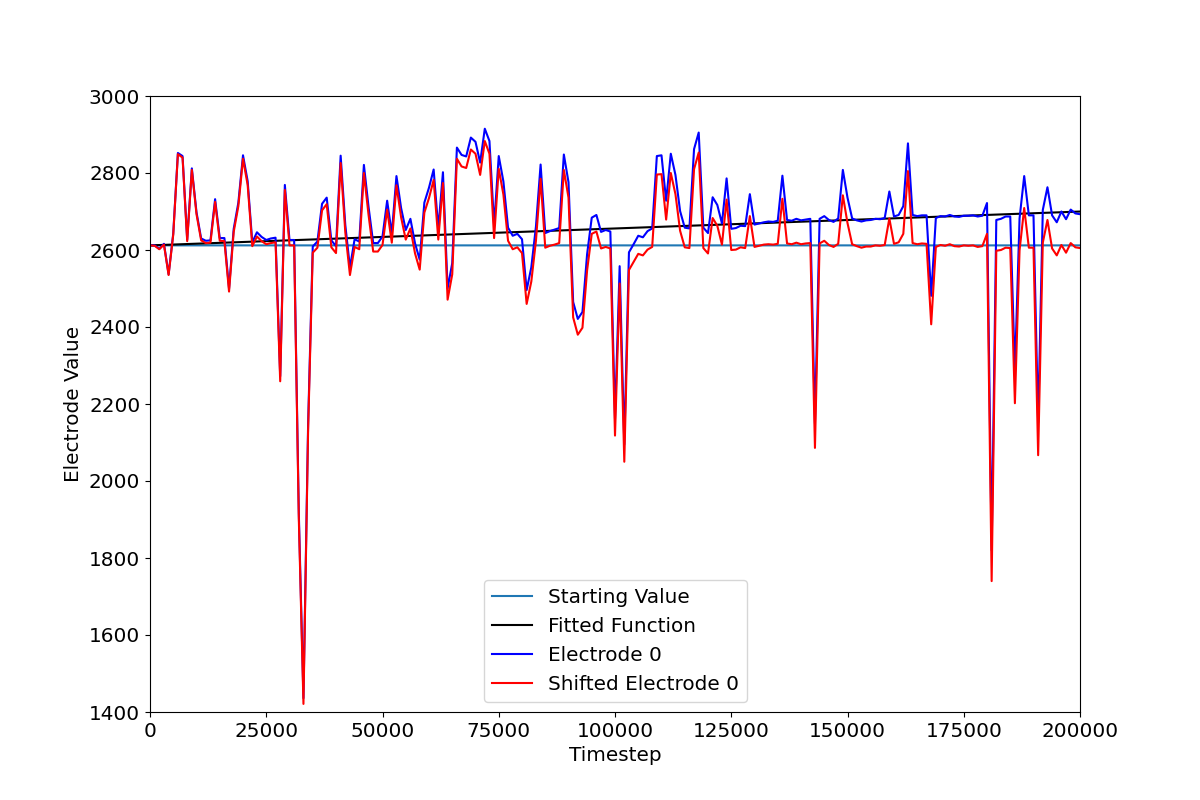

In [11]:
all_transformed_values_flat = np.array(all_values)
steps = 1000

fig_, (ax2) = plt.subplots(1, 1, figsize=(12, 8))
ax2.plot(indices, [all_baseline_values[0,k] for v in all_baseline_values[:, k]], label="Starting Value")
ax2.plot(indices, complete_res[k], label="Fitted Function", color="black")

ax2.plot(np.arange(len(all_transformed_values_flat))[::steps], all_transformed_values_flat[::steps, k], label=f"Electrode {k}", alpha=1, color="blue")



for i in range (19):
    all_transformed_values_flat[:, i] = all_transformed_values_flat[:, i] - (fitted_values[i].detach().numpy()-all_baseline_values[0,k])
    
#ax2[1].plot(indices, [electrodes_default[k] for v in all_baseline_values[:, k]], label="Default")
ax2.plot(np.arange(len(all_transformed_values_flat))[::steps], all_transformed_values_flat[::steps, k], label=f"Shifted Electrode {k}", color="red")

ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Electrode Value")
plt.ylim(1400, 3000)
plt.xlim(0, 200000)
#ax2[1].legend()
#ax2[1].set_xlabel("Timestep")
#ax2[1].set_ylabel("Electrode Value")

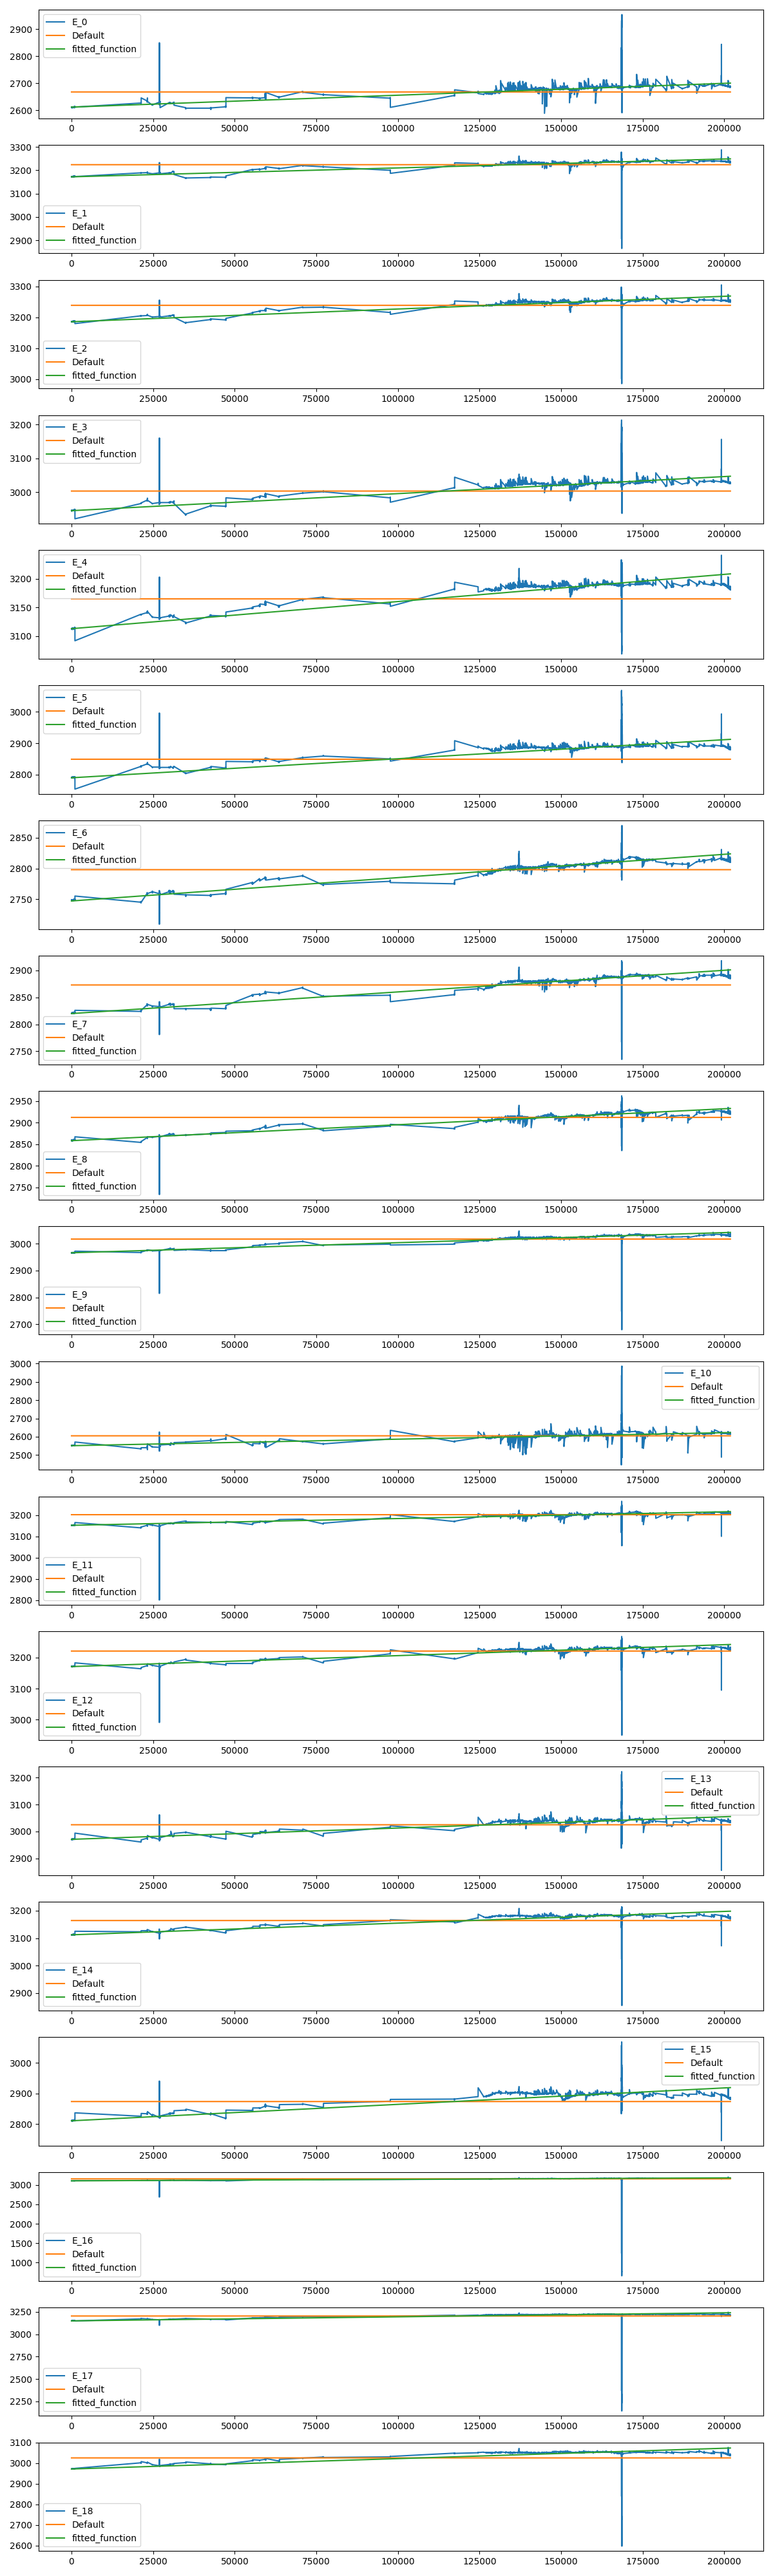

In [11]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

for i in range (19):
    ax2[i].plot(indices, all_baseline_values[:,i],label="E_"+str(i))
    ax2[i].plot(indices, [electrodes_default[i] for v in all_baseline_values[:, i]], label="Default")
    ax2[i].plot(indices, complete_res[i], label="fitted_function")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

# Visualize Data after Error removed

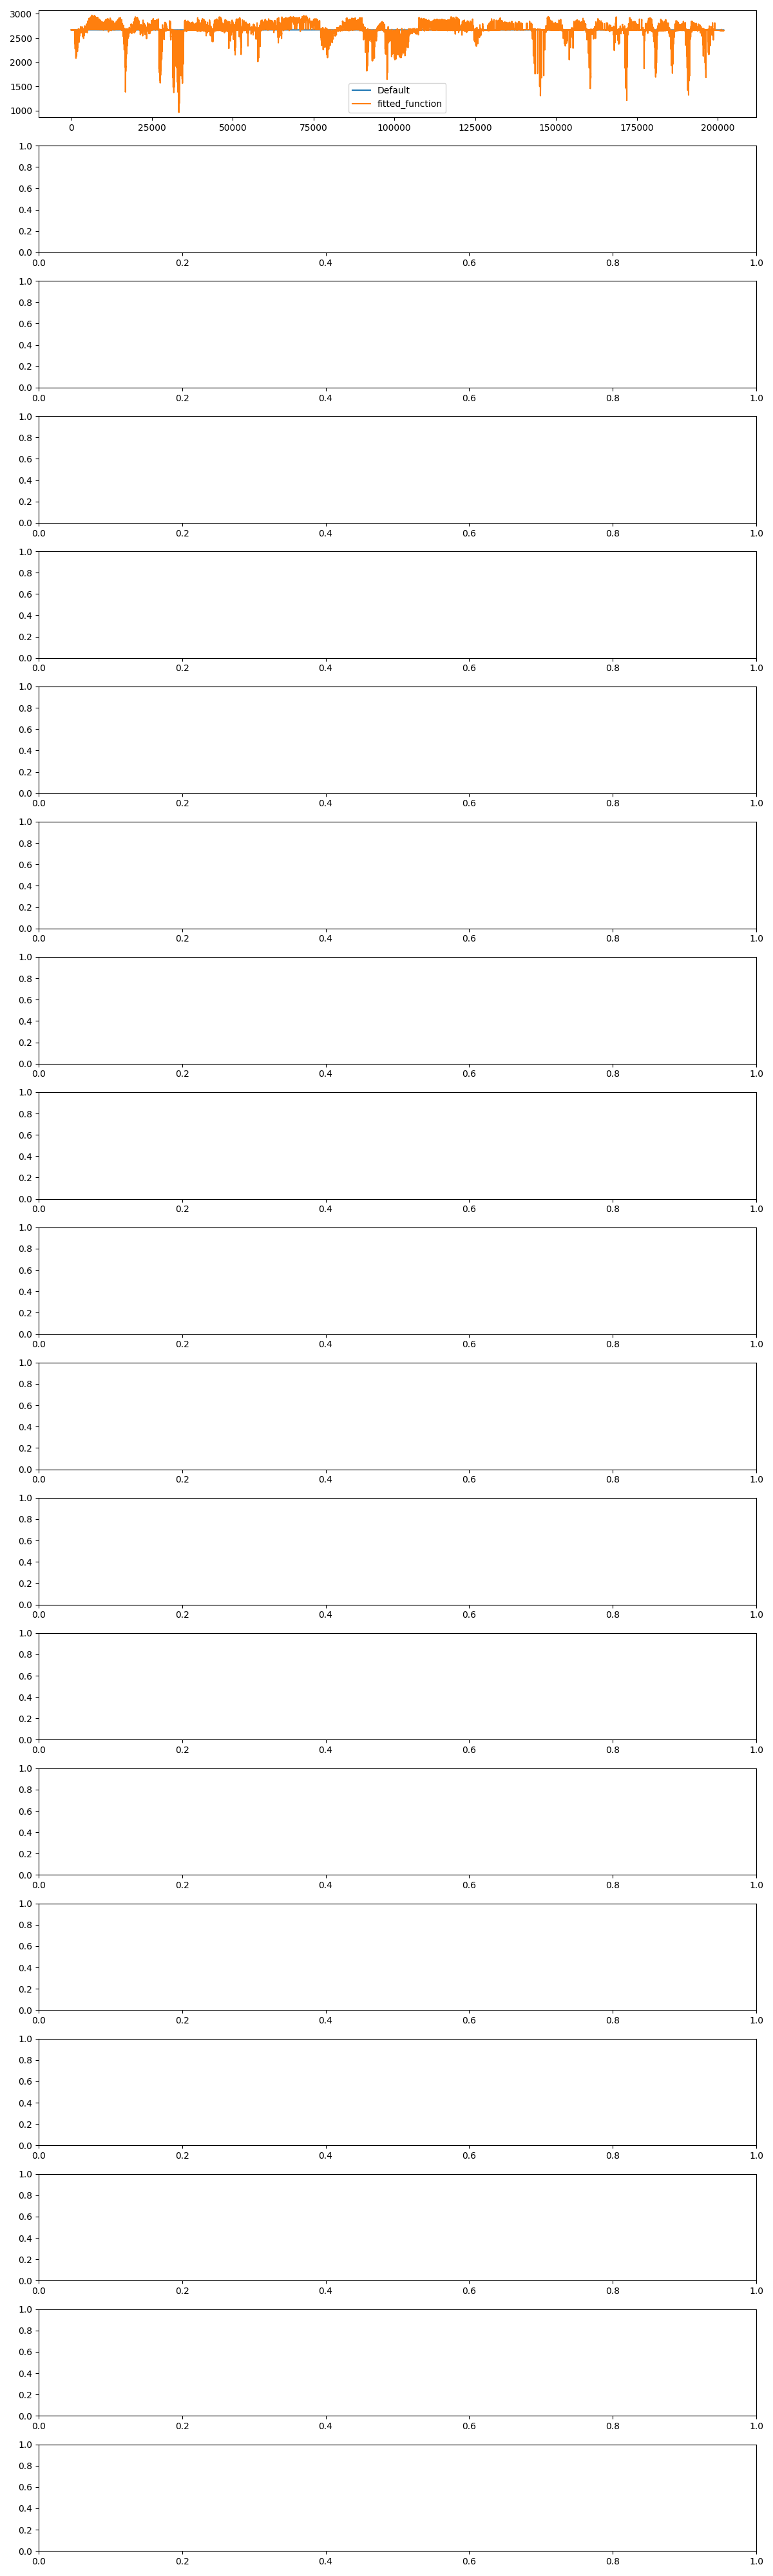

In [14]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

all_transformed_values_flat = np.array(all_values)
for i in range (19):
    all_transformed_values_flat[:, i] = all_transformed_values_flat[:, i] - (fitted_values[i].detach().numpy()-electrodes_default[i])
    
for i in range (19):
    # ax2[i].plot(indices, all_baseline_values[:,i],label="E_"+str(i))
    ax2[i].plot(indices, [electrodes_default[i] for v in all_baseline_values[:, i]], label="Default")
    ax2[i].plot(all_transformed_values_flat[:, i], label="fitted_function")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

# Stick Indenter

In [64]:
cool_down_steps = 200
in_contact = False
is_cooled_down = True
active_steps = 0
all_values_stick = []
all_baseline_values_stick = []

stick_trajecs = 0

indices_stick = []
forces_stick = []
forces_to_contact_stick = []
i = 0
force_strength = 0.0
for ind, (topic, msg, t) in enumerate(bag_stick.read_messages(topics=['rh/tactile', 'wireless_ft/wrench_3'])):
    
    if topic == 'wireless_ft/wrench_3':
        force = np.array([msg.wrench.force.x, msg.wrench.force.y, msg.wrench.force.z])
        force_strength = np.linalg.norm(force)
        forces_stick.append(force_strength)
        if force_strength > 0.3:
            if not in_contact:
                stick_trajecs += 1
            in_contact = True
            is_cooled_down = False
            active_steps = 0
            
        if force_strength < 0.3:
            in_contact = False
            active_steps += 1
            if active_steps >= cool_down_steps:
                is_cooled_down = True
    elif topic == 'rh/tactile':
        forces_to_contact_stick.append(force_strength)
        electrode_values = np.array(msg.tactiles[0].electrodes)
        all_values_stick.append(electrode_values)
        if not in_contact and is_cooled_down:
            all_baseline_values_stick.append(electrode_values)
            indices_stick.append(i)
        i += 1
            
all_values_stick = np.array(all_values_stick)
all_baseline_values_stick = np.array(all_baseline_values_stick)

all_forces_stick = np.array(forces_stick)
all_forces_to_contact_stick = np.array(forces_to_contact_stick)
print(all_forces_stick.shape)
print(all_forces_to_contact_stick.shape)
print(all_values_stick.shape)
print(all_baseline_values_stick.shape)

(376314,)
(313388,)
(313388, 19)
(49594, 19)


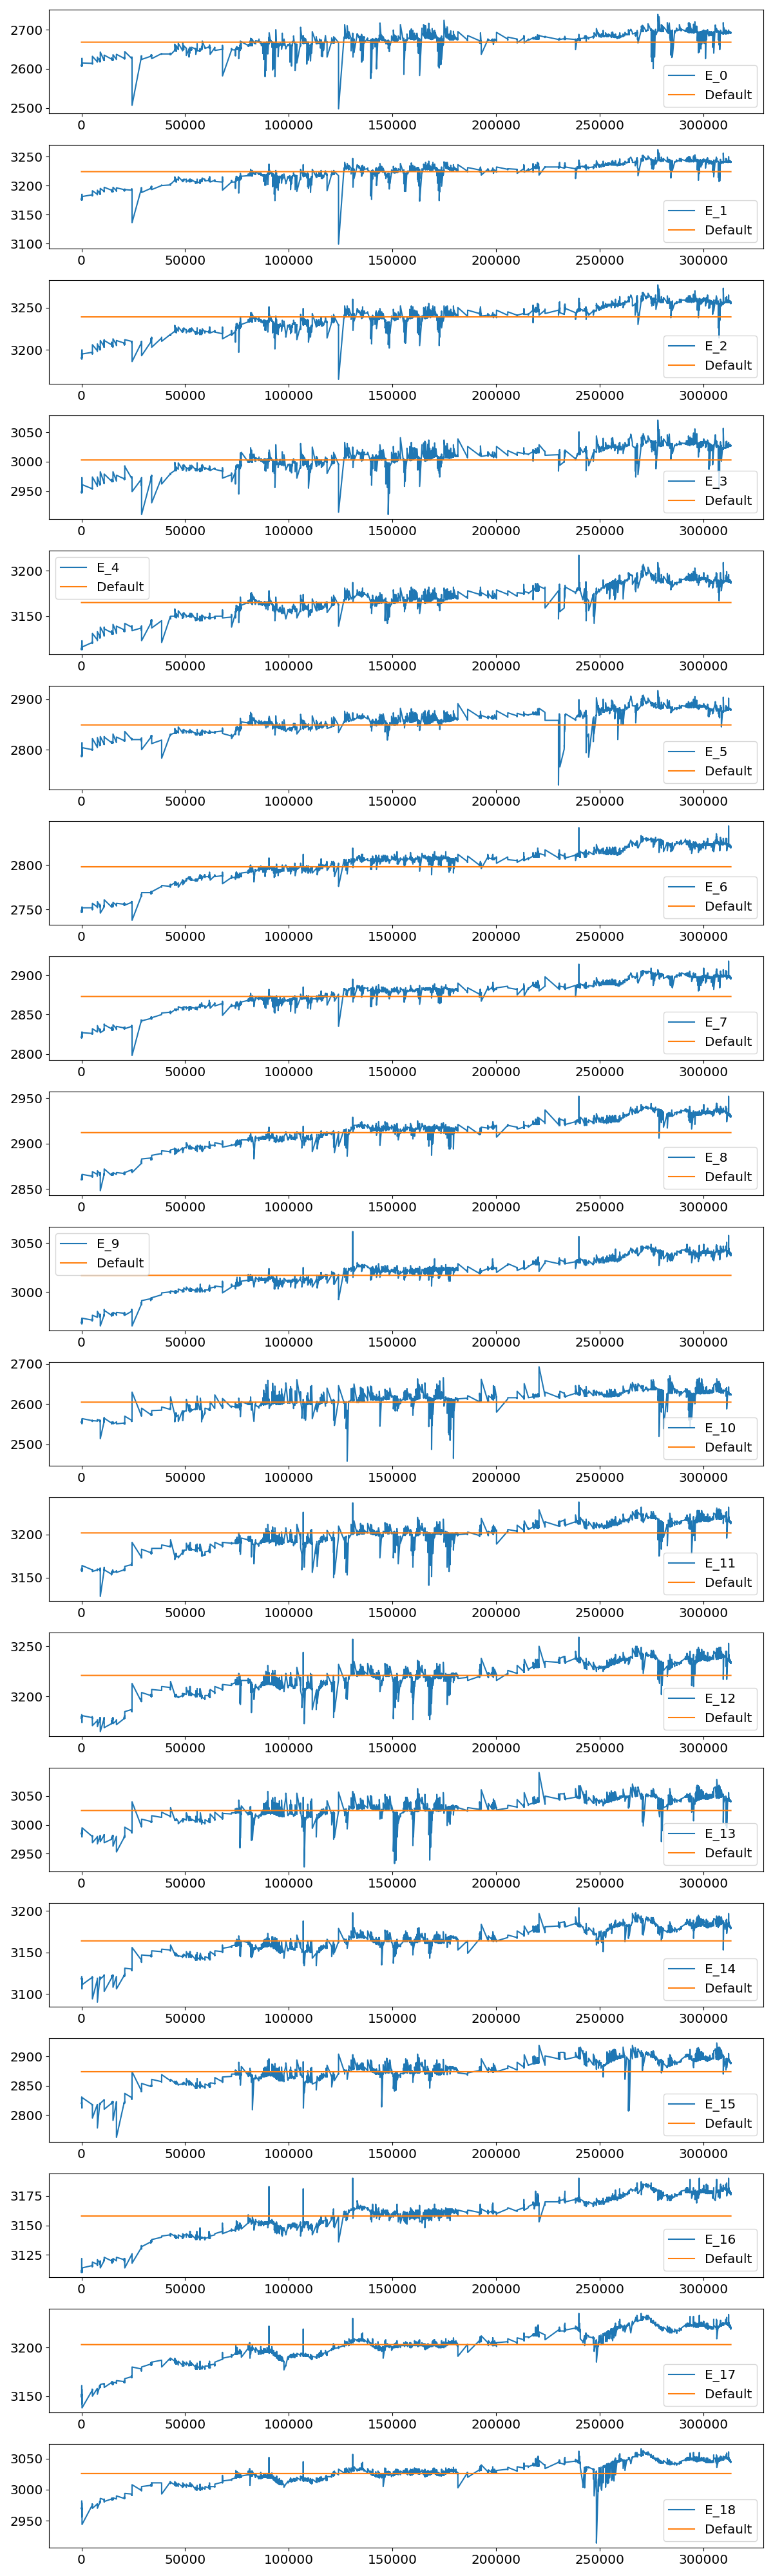

In [65]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

for i in range (19):
    ax2[i].plot(indices_stick, all_baseline_values_stick[:,i],label="E_"+str(i))
    ax2[i].plot(indices_stick, [electrodes_default[i] for v in all_baseline_values_stick[:, i]], label="Default")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

In [66]:
from pathlib import Path
import torch
import tqdm

complete_res_stick = []
fitted_values_stick = []


for i in tqdm.tqdm(range(19)):
    function_weights = torch.tensor([0, all_baseline_values_stick[0][i]], dtype=torch.float, requires_grad=True)
    
    ground_truth = torch.tensor(all_baseline_values_stick, requires_grad=True, dtype=torch.float)[:, i]
    input_values = torch.tensor(indices_stick, dtype=torch.float)
    steps = 10000
    optimizer = torch.optim.Adam([function_weights], lr= 1e-5)
    def forward(va):
        return function_weights[0] * va + function_weights[1]
    
    def loss(res, labels):
        return torch.mean(torch.abs(labels - res))

    dist = 0
    for k in range(steps):
        optimizer.zero_grad()
        res = forward(input_values)
        dist = loss(res, ground_truth)
        # pbar.set_description(f"Loss: {dist}")
        dist.backward()
        optimizer.step()
    
    print(f"{function_weights[0]} * x + {function_weights[1]}\nLoss: {dist}")
    
    fitted_values_stick.append(forward(torch.tensor(np.arange(len(all_values_stick)))))
    
    error_path = Path(f"./data/electrode_error_weights/stick/{i}")
    error_path.mkdir(parents=True, exist_ok=True)
    # np.save(error_path / "weights.npy", function_weights.detach().numpy())
    # np.save(error_path / "loss.npy", dist.detach().numpy())
    complete_res_stick.append(forward(input_values).detach().numpy())

  5%|▌         | 1/19 [00:13<03:56, 13.14s/it]

0.00030910249915905297 * x + 2609.0
Loss: 14.038317680358887


 11%|█         | 2/19 [00:25<03:34, 12.60s/it]

0.00023787663667462766 * x + 3177.0
Loss: 9.647894859313965


 16%|█▌        | 3/19 [00:37<03:21, 12.61s/it]

0.0002495093212928623 * x + 3190.0
Loss: 9.698505401611328


 21%|██        | 4/19 [00:50<03:07, 12.49s/it]

0.0002991890942212194 * x + 2948.0
Loss: 12.068497657775879


 26%|██▋       | 5/19 [01:03<02:56, 12.59s/it]

0.00028539291815832257 * x + 3114.0
Loss: 11.004972457885742


 32%|███▏      | 6/19 [01:16<02:46, 12.84s/it]

0.00036198823363520205 * x + 2788.0
Loss: 14.949414253234863


 37%|███▋      | 7/19 [01:27<02:26, 12.19s/it]

0.00027664221124723554 * x + 2747.0
Loss: 12.013618469238281


 42%|████▏     | 8/19 [01:35<02:00, 10.98s/it]

0.0002837352512869984 * x + 2821.0
Loss: 12.3307466506958


 47%|████▋     | 9/19 [01:46<01:50, 11.09s/it]

0.0002717640018090606 * x + 2860.0
Loss: 10.969718933105469


 53%|█████▎    | 10/19 [01:56<01:35, 10.63s/it]

0.000266468123300001 * x + 2968.0
Loss: 10.625030517578125


 58%|█████▊    | 11/19 [02:07<01:25, 10.65s/it]

0.00028975485474802554 * x + 2555.0
Loss: 11.407719612121582


 63%|██████▎   | 12/19 [02:20<01:20, 11.49s/it]

0.0002220809255959466 * x + 3159.0
Loss: 7.530765533447266


 68%|██████▊   | 13/19 [02:33<01:11, 11.89s/it]

0.00022298548719845712 * x + 3179.0
Loss: 7.4058427810668945


 74%|███████▎  | 14/19 [02:49<01:05, 13.15s/it]

0.0002361811784794554 * x + 2985.0
Loss: 7.988903522491455


 79%|███████▉  | 15/19 [03:00<00:50, 12.58s/it]

0.0002545354946050793 * x + 3118.0
Loss: 8.822704315185547


 84%|████████▍ | 16/19 [03:11<00:36, 12.02s/it]

0.0003000550204887986 * x + 2820.0
Loss: 10.963011741638184


 89%|████████▉ | 17/19 [03:20<00:22, 11.15s/it]

0.0002539217530284077 * x + 3111.0
Loss: 9.419978141784668


 95%|█████████▍| 18/19 [03:29<00:10, 10.51s/it]

0.00027719049830920994 * x + 3151.0
Loss: 10.120636940002441


100%|██████████| 19/19 [03:41<00:00, 11.68s/it]

0.00030649485415779054 * x + 2970.0
Loss: 11.7813138961792


NameError: name 'indices_stick' is not defined

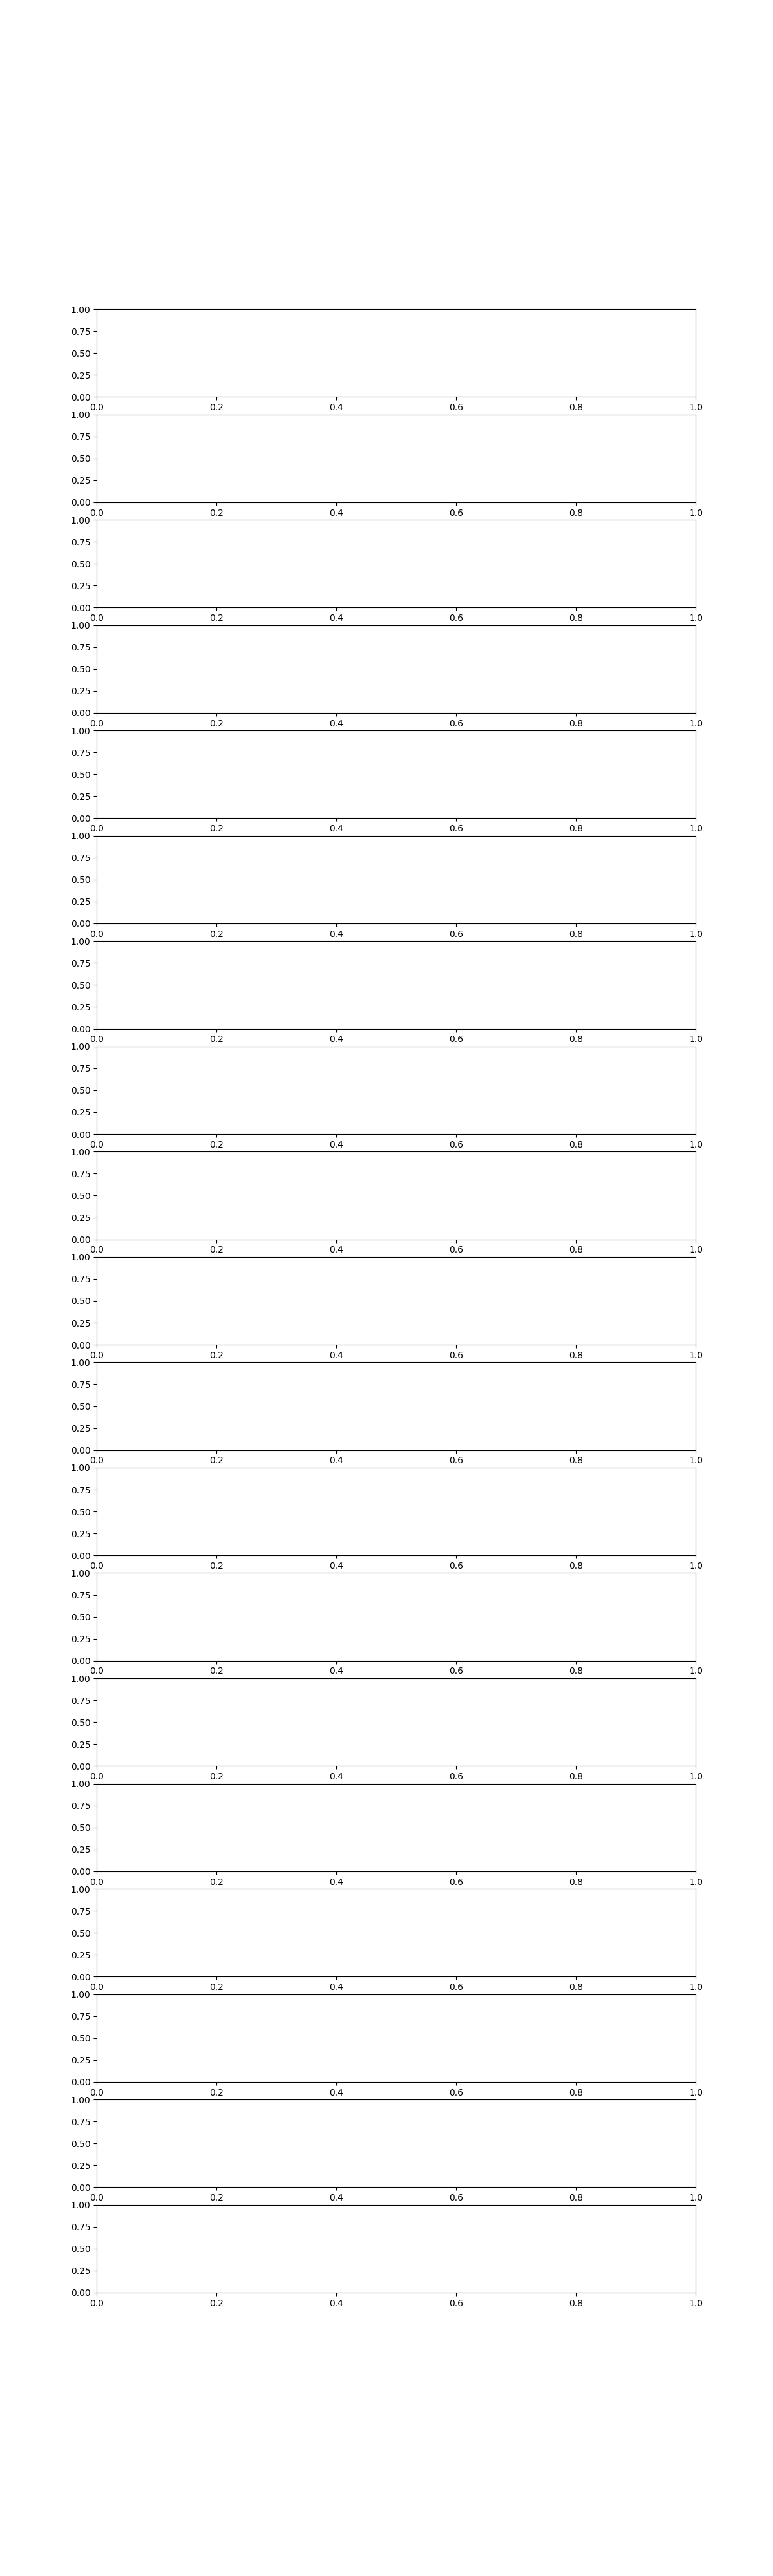

In [15]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

for i in range (19):
    ax2[i].plot(indices_stick, all_baseline_values_stick[:,i],label="E_"+str(i))
    ax2[i].plot(indices_stick, [electrodes_default[i] for v in all_baseline_values_stick[:, i]], label="Default")
    ax2[i].plot(indices_stick, complete_res_stick[i], label="fitted_function")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

In [30]:
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

all_transformed_values_stick = np.array(all_values_stick)
for i in range (19):
    all_transformed_values_stick[:, i] = all_transformed_values_stick[:, i] - (fitted_values_stick[i].detach().numpy()-electrodes_default[i])

for i in range (19):
    # ax2[i].plot(indices, all_baseline_values[:,i],label="E_"+str(i))
    ax2[i].plot(indices_stick, [electrodes_default[i] for v in all_baseline_values_stick[:, i]], label="Default")
    ax2[i].plot(all_transformed_values_stick[:, i], label="fitted_function")
    #ax4.set_ylim(2500, 3500)
    # show legend
    ax2[i].legend()
#ax2.set_ylim(2300, 3400)
#ax2.set_xlim(31080, 31250)
plt.tight_layout()
plt.show()

# NVIDIA Data Processing

## Stick

In [14]:
nvidia_format_stick = (all_transformed_values_stick/4095) - (all_transformed_values_stick[0]/4095)

NameError: name 'all_transformed_values_stick' is not defined

In [32]:
# plt.show()
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

for i in range(19):
    ax2[i].plot(nvidia_format_stick[:, i], label="tared values")
    ax2[i].legend()

plt.tight_layout()
plt.show()

## Flat

In [15]:
nvidia_format_flat = (all_transformed_values_flat/4095) - (all_transformed_values_flat[0]/4095)

NameError: name 'all_transformed_values_flat' is not defined

In [34]:
# plt.show()
fig_, (ax2) = plt.subplots(19, 1, figsize=(12, 40))

for i in range(19):
    ax2[i].plot(nvidia_format_flat[:, i], label="tared values")
    ax2[i].legend()

plt.tight_layout()
plt.show()

In [35]:
print("##########Flat###########")
for i in range(19):
    print(f"Electrode {i}: min -> {np.min(nvidia_format_flat[:, i])} | max -> {np.max(nvidia_format_flat[:, i])}")
    
print("##########Stick###########")
for i in range(19):
    print(f"Electrode {i}: min -> {np.min(nvidia_format_stick[:, i])} | max -> {np.max(nvidia_format_stick[:, i])}")
    

In [36]:
fig_, (ax2) = plt.subplots(1, 1)
ax2.boxplot(nvidia_format_stick)
plt.show()

In [37]:
fig_, (ax2) = plt.subplots(1, 1)
ax2.boxplot(nvidia_format_flat)
plt.show()

## Store Values

In [50]:
import h5py

with h5py.File("../Data/datasets/biotac_single_contact_response/ruppel_flat_in_nvidia.hdf5", 'a') as f:
    grp = f.create_group("electrode_vals")
    grp["data"] = nvidia_format_flat
    # f["electrode_vals"] = f.create_dataset("data", data=nvidia_format_flat)

In [51]:
filtered_data_flat = nvidia_format_flat[all_forces_to_contact_flat > 0.3]
no_contact_data_flat = nvidia_format_flat[all_forces_to_contact_flat <= 0.3]
np.random.shuffle(no_contact_data_flat)
no_contact_data_flat = no_contact_data_flat[:(flat_trajecs*2)]

relevant_data_flat = np.concatenate([filtered_data_flat, no_contact_data_flat])
print(filtered_data_flat.shape)
print(no_contact_data_flat.shape)
print(relevant_data_flat.shape)
with h5py.File("../Data/datasets/biotac_single_contact_response/ruppel_flat_in_nvidia_reduced.hdf5", 'a') as f:
    grp = f.create_group("electrode_vals")
    grp["data"] = relevant_data_flat

In [52]:

with h5py.File("../Data/datasets/biotac_single_contact_response/ruppel_stick_in_nvidia.hdf5", 'a') as f:
    grp = f.create_group("electrode_vals")
    grp["data"] = nvidia_format_stick

In [53]:
filtered_data_stick = nvidia_format_stick[all_forces_to_contact_stick > 0.3]

no_contact_data_stick = nvidia_format_stick[all_forces_to_contact_stick <= 0.3]
np.random.shuffle(no_contact_data_stick)
no_contact_data_stick = no_contact_data_stick[:(stick_trajecs*2)]
relevant_data_stick = np.concatenate([filtered_data_stick, no_contact_data_stick])
print(filtered_data_stick.shape)
print(no_contact_data_stick.shape)
print(relevant_data_stick.shape)

with h5py.File("../Data/datasets/biotac_single_contact_response/ruppel_stick_in_nvidia_reduced.hdf5", 'a') as f:
    grp = f.create_group("electrode_vals")
    grp["data"] = relevant_data_stick